In [1]:
import numpy as np
import pandas as pd
import pandas_datareader.data as pdr
import matplotlib.pyplot as plt
import datetime
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Data load
df = pd.read_csv('/content/drive/MyDrive/bs_1.csv', encoding='cp949', index_col=0)
df = df.dropna()
x = df.iloc[:,:-1]
y = df.iloc[:,-1:]

In [5]:
# Training/Test ratio = 7:3
Train_ratio = 0.7
Test_ratio = 0.3

# Data Division
train_x = x.iloc[0:int(len(df)*Train_ratio),:]
train_y = y.iloc[0:int(len(df)*Train_ratio),:]
test_x = x.iloc[int(len(df)*Train_ratio):,:]
test_y = y.iloc[int(len(df)*Train_ratio):,:]

In [6]:
# Normalizing
minmax_x = MinMaxScaler()
minmax_y = MinMaxScaler()

train_x = minmax_x.fit_transform(train_x)
train_y = minmax_y.fit_transform(train_y)
test_x = minmax_x.fit_transform(test_x)
test_y = minmax_y.fit_transform(test_y)

# Check Data pre-processing
print("Training shape : ", train_x.shape, train_y.shape)
print("Test shape : ",test_x.shape, test_y.shape)

Training shape :  (79, 20) (79, 1)
Test shape :  (34, 20) (34, 1)


In [7]:
# Torch Variable 형태로 변경(data/grad/grad_fn)
train_x_tensor = Variable(torch.Tensor(train_x))
train_y_tensor = Variable(torch.Tensor(train_y))
test_x_tensor = Variable(torch.Tensor(test_x))
test_y_tensor = Variable(torch.Tensor(test_y))

print("After torch variable shape_Train : ",train_x_tensor.shape, train_y.shape)
print("After torch Variable shape_Test : ",test_x_tensor.shape, test_y_tensor.shape)

After torch variable shape_Train :  torch.Size([79, 20]) (79, 1)
After torch Variable shape_Test :  torch.Size([34, 20]) torch.Size([34, 1])


In [8]:
train_x_tensor_final = torch.reshape(train_x_tensor, (train_x_tensor.shape[0], 1, train_x_tensor.shape[1]))
train_y_tensor_final = torch.reshape(train_y_tensor, (train_y_tensor.shape[0], 1, train_y_tensor.shape[1]))
test_x_tensor_final = torch.reshape(test_x_tensor, (test_x_tensor.shape[0], 1, test_x_tensor.shape[1]))
test_y_tensor_final = torch.reshape(test_y_tensor,(test_y_tensor.shape[0], 1, test_y_tensor.shape[1]) )

print(train_x_tensor_final.shape, test_x_tensor_final.shape)

torch.Size([79, 1, 20]) torch.Size([34, 1, 20])


In [9]:
# Check GPU setting
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [10]:
# GPU setting
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(torch.cuda.get_device_name(0)) #Google colab = TESLA T4

Tesla V100-SXM2-16GB


In [11]:
# LSTM definition
class LSTM_Model(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM_Model, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

input_size = train_x_tensor_final.shape[2]
hidden_size = 128
num_layers = 2
output_size = 1

model = LSTM_Model(input_size, hidden_size, num_layers, output_size)

In [12]:
!pip3 install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 763.4/763.4 kB 8.4 MB/s eta 0:00:00


In [13]:
# LSTM training
num_epochs = 500
learning_rate = 0.001

from torchmetrics import R2Score

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    model.train()
    outputs = model(train_x_tensor_final)
    optimizer.zero_grad()

    loss = criterion(outputs, torch.reshape(train_y_tensor_final, (train_y_tensor_final.shape[0], train_y_tensor_final.shape[1])))
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [1/500], Loss: 0.4009
Epoch [11/500], Loss: 0.2321
Epoch [21/500], Loss: 0.0443
Epoch [31/500], Loss: 0.0510
Epoch [41/500], Loss: 0.0412
Epoch [51/500], Loss: 0.0343
Epoch [61/500], Loss: 0.0330
Epoch [71/500], Loss: 0.0305
Epoch [81/500], Loss: 0.0280
Epoch [91/500], Loss: 0.0256
Epoch [101/500], Loss: 0.0232
Epoch [111/500], Loss: 0.0208
Epoch [121/500], Loss: 0.0186
Epoch [131/500], Loss: 0.0168
Epoch [141/500], Loss: 0.0154
Epoch [151/500], Loss: 0.0143
Epoch [161/500], Loss: 0.0135
Epoch [171/500], Loss: 0.0127
Epoch [181/500], Loss: 0.0119
Epoch [191/500], Loss: 0.0112
Epoch [201/500], Loss: 0.0105
Epoch [211/500], Loss: 0.0099
Epoch [221/500], Loss: 0.0093
Epoch [231/500], Loss: 0.0087
Epoch [241/500], Loss: 0.0083
Epoch [251/500], Loss: 0.0079
Epoch [261/500], Loss: 0.0076
Epoch [271/500], Loss: 0.0074
Epoch [281/500], Loss: 0.0072
Epoch [291/500], Loss: 0.0070
Epoch [301/500], Loss: 0.0069
Epoch [311/500], Loss: 0.0068
Epoch [321/500], Loss: 0.0067
Epoch [331/500], Loss

In [15]:
r2 = R2Score()

# LSTM evaluation
model.eval()
with torch.no_grad():
    test_outputs = model(test_x_tensor_final)
    test_loss = criterion(test_outputs, torch.reshape(test_y_tensor_final, (test_y_tensor_final.shape[0], test_y_tensor_final.shape[1])))
    print(f"Test Loss: {test_loss.item():.4f}")

Test Loss: 0.0399


In [16]:
# prediction
predicted = np.concatenate((minmax_x.inverse_transform(test_x), minmax_y.inverse_transform(test_outputs.numpy())), axis=1)[:, -1]
actual = np.concatenate((minmax_x.inverse_transform(test_x), minmax_y.inverse_transform(test_y.reshape(-1, 1))), axis=1)[:, -1]

In [17]:
predicted

array([414150.375  , 423862.3125 , 408475.5625 , 422394.34375,
       427808.21875, 428094.84375, 400125.71875, 485404.96875,
       438572.65625, 446291.5    , 433380.09375, 432177.84375,
       430358.65625, 419440.28125, 443261.25   , 423370.625  ,
       458978.125  , 431983.5    , 422737.9375 , 466051.15625,
       440108.59375, 457617.71875, 429069.9375 , 444017.5625 ,
       454700.9375 , 419887.34375, 433923.46875, 458007.65625,
       448898.46875, 417008.6875 , 443300.625  , 469673.375  ,
       457049.34375, 466781.28125])

In [18]:
actual

array([392011.75, 406567.  , 420941.75, 431403.5 , 417955.25, 427910.75,
       398213.75, 486997.5 , 436702.25, 469238.5 , 437709.  , 457380.  ,
       397369.25, 400622.  , 458593.25, 413824.25, 440907.25, 440329.25,
       407724.25, 449579.25, 463717.5 , 468135.  , 390666.5 , 480851.5 ,
       431194.25, 384904.25, 437823.25, 423563.75, 400011.  , 417851.25,
       430718.  , 465645.25, 467042.  , 470912.25])

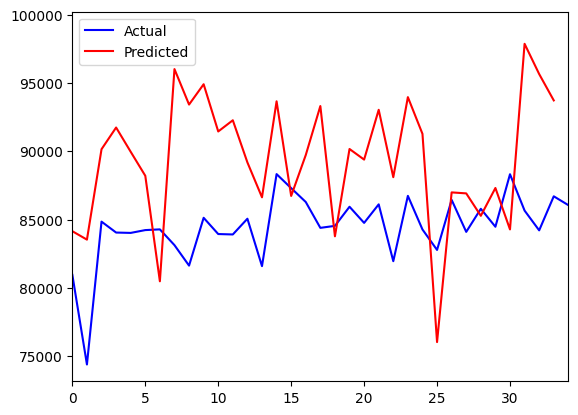

In [19]:
# Actual graph
actual_data = np.concatenate((minmax_x.inverse_transform(train_x_tensor_final.view(-1, input_size).cpu().numpy()), minmax_y.inverse_transform(train_y_tensor_final.view(-1, 1).cpu().numpy())), axis=1)
mean_actual = actual_data.mean(axis=1)

plt.plot(mean_actual, label='Actual', color='blue')

# Predicted graph
predicted_data = np.concatenate((minmax_x.inverse_transform(test_x_tensor_final.view(-1, input_size).cpu().numpy()), minmax_y.inverse_transform(test_outputs.view(-1, 1).cpu().numpy())), axis=1)
mean_predicted = predicted_data.mean(axis=1)

plt.plot(mean_predicted, label='Predicted', color='red')
plt.xlim(0, len(mean_predicted))

plt.legend()
plt.show()

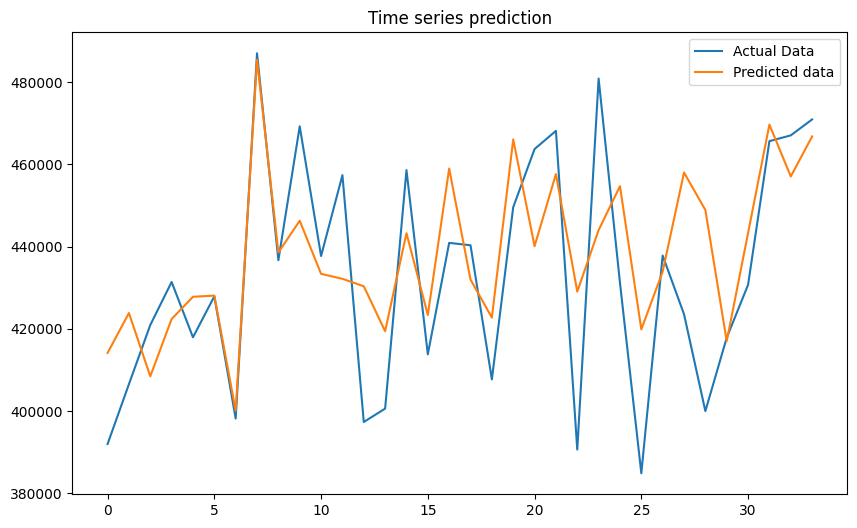

In [20]:
#Figure
plt.figure(figsize = (10,6)) # Plotting
plt.plot(actual, label = 'Actual Data')
plt.plot(predicted, label = 'Predicted data')
plt.title('Time series prediction')
plt.legend()
plt.show()

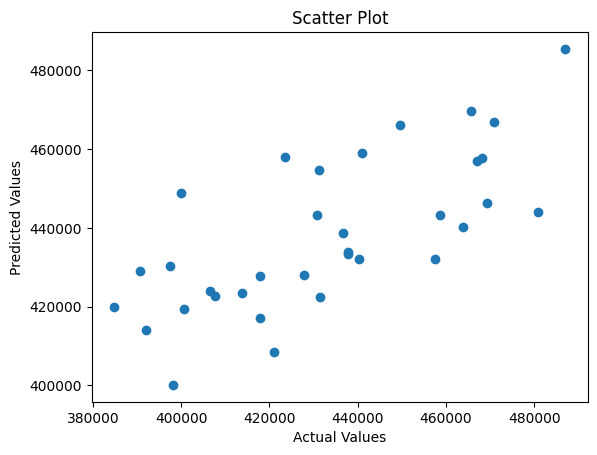

In [21]:
# 산포도 그래프 (Scatter Plot)
plt.scatter(actual, predicted)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Scatter Plot")
plt.show()

In [22]:
import copy
data_combined_x = np.concatenate((train_x, test_x), axis=0)
data_combined_y = np.concatenate((train_y, test_y), axis=0)
PlotEstimated = np.empty_like(np.concatenate((data_combined_x, data_combined_y), axis=1))
PlotEstimated[:, :] = np.nan

In [23]:
result = predicted.reshape(34,1)

In [24]:
#PlotEstimated의 복사본
# trainPlotEstimated = copy.deepcopy(PlotEstimated)
# trainPlotEstimated[self.m_window_step:len(self.m_TrainEstimated)+self.m_window_step, :] = self.m_TrainEstimated
testPlotEstimated = copy.deepcopy(PlotEstimated)
testPlotEstimated[79:, -1:] = result

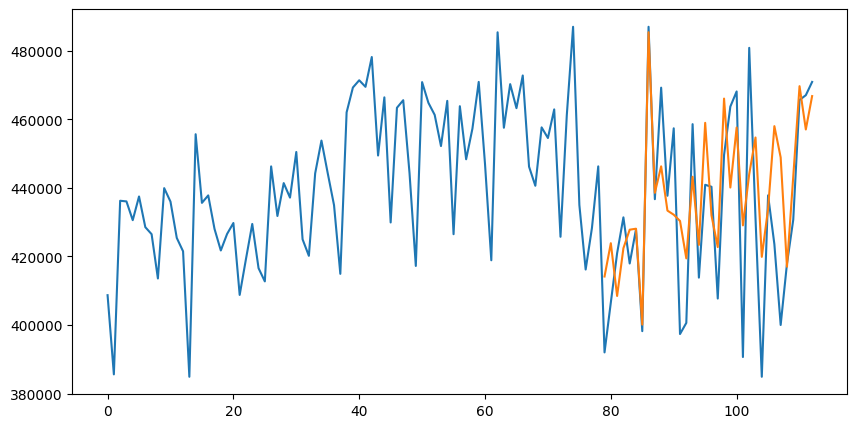

In [25]:
plt.figure(figsize=(10,5))

#실제 데이터, 학습데이터, 테스트 데이터의 예측값 그래프로
plt.plot(minmax_y.inverse_transform(data_combined_y))
# plt.plot(trainPlotEstimated)
plt.plot(testPlotEstimated)
plt.show()